In [ ]:
!unzip -q /content/TestDataSet.zip -d /content

In [ ]:
import json, os, math, numpy as np, torch, torch.nn.functional as F
import torchvision
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.auto import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MEAN   = np.array([0.485, 0.456, 0.406])
STD    = np.array([0.229, 0.224, 0.225])

DATASET_PATH = "/content/TestDataSet"
LABELS_JSON  = f"{DATASET_PATH}/labels_list.json"
BATCH_SIZE   = 32

In [ ]:
def official_syn2idx(cache_dir: Path):
    f = cache_dir / "imagenet_class_index.json"
    if not f.exists():
        from torchvision.datasets.utils import download_url
        download_url(
            "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json",
            str(cache_dir))
    idx2syn = {int(k): v[0] for k, v in json.load(open(f)).items()}
    return {v: k for k, v in idx2syn.items()}


def build_subset_mapping(root: Path, labels_json: Path):
    wanted = {int(str(x).split(":",1)[0]) for x in json.load(open(labels_json))}
    syn2idx = official_syn2idx(root)
    mapping = {syn: syn2idx[syn] for syn in os.listdir(root)
               if syn.startswith("n") and syn2idx.get(syn) in wanted}
    if len(mapping) != len(wanted):
        missing = wanted.difference(mapping.values())
        raise RuntimeError(f"lose ImageNet file: {sorted(missing)}")
    return mapping

def load_subset(path, labels_json, batch_size=32):
    tfm = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(MEAN, STD)])
    mapping = build_subset_mapping(Path(path), Path(labels_json))
    ds = torchvision.datasets.ImageFolder(path, transform=tfm)
    # overwrite class_to_idx / samples / targets
    ds.class_to_idx = mapping
    ds.samples = [(fp, mapping[Path(fp).parent.name]) for fp,_ in ds.samples]
    ds.targets = [t for _,t in ds.samples]
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False,
                    num_workers=2, pin_memory=True)
    return ds, dl

In [ ]:
#@title Task 1 – Evaluate pretrained ResNet‑34 on the 100‑class subset

tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

mapping = build_subset_mapping(Path(DATASET_PATH), Path(LABELS_JSON))
dataset = torchvision.datasets.ImageFolder(DATASET_PATH, transform=tfm)

dataset.class_to_idx = mapping
new_samples = [(fp, mapping[Path(fp).parent.name]) for fp, _ in dataset.samples]
dataset.samples  = new_samples
dataset.targets  = [t for _, t in new_samples]

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False,
                    num_workers=2, pin_memory=True)
ds, dl = load_subset(DATASET_PATH, LABELS_JSON, batch_size=32)
print(f"✔️  Loaded {len(dataset)} images from {len(dataset.classes)} classes")

# ---------- Test ----------
def topk_acc(logits, target, k=5):
    _, pred = logits.topk(k, 1, True, True)
    return (pred.eq(target.view(-1,1)).any(1).float().mean().item())*100

def evaluate(model, dl):
    model.eval(); t1=t5=n=0
    with torch.no_grad():
        for x,y in dl:
            x,y = x.to(DEVICE), y.to(DEVICE)
            out = model(x); b = y.size(0)
            t1 += topk_acc(out,y,1)*b;  t5 += topk_acc(out,y,5)*b;  n+=b
    return t1/n, t5/n

resnet34 = torchvision.models.resnet34(weights="IMAGENET1K_V1").to(DEVICE)
top1, top5 = evaluate(resnet34, loader)

print(f"ResNet‑34 accuracy on TestDataSet")
print(f"   • Top‑1 : {top1:5.2f}%")
print(f"   • Top‑5 : {top5:5.2f}%")



✔️  Loaded 500 images from 100 classes
ResNet‑34 accuracy on TestDataSet
   • Top‑1 : 76.00%
   • Top‑5 : 94.20%


FGSM generating:   0%|          | 0/16 [00:00<?, ?it/s]

L_inf max difference (normalized) : 0.1400  (should ≤ 0.02)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f413c79fa60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7f413c79fa60> 
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():
^ ^ ^
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  assert self._parent_pid == os.getpid(), 'can only test a child process'      
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^^
^  File "/u


ResNet‑34 on FGSM set — Top‑1: 6.20%   Top‑5: 35.60%


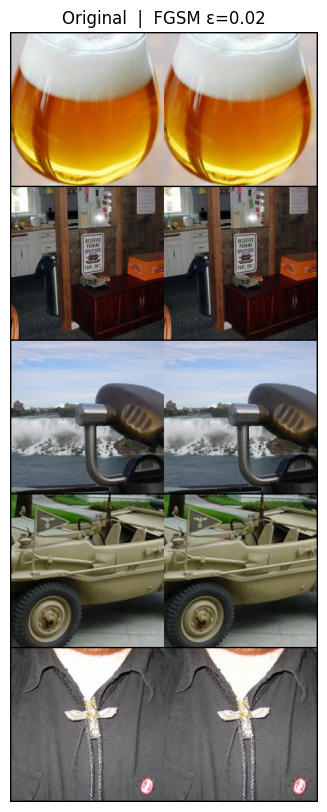


Saving perturbed images to /content/AdvTestSet1_FGSM ...
Done ✓


In [ ]:
#@title Task 2 – FGSM (ε = 0.02) pixel‑wise attack
import os, numpy as np, torch, matplotlib.pyplot as plt
from pathlib import Path
from torchvision.utils import make_grid, save_image
from tqdm.auto import tqdm

EPS = 0.02
OUT_DIR = Path("/content/AdvTestSet1_FGSM")

def fgsm_attack(model, x, y, eps):
    x_adv = x.clone().detach().requires_grad_(True)
    model.zero_grad()
    torch.nn.functional.cross_entropy(model(x_adv), y).backward()
    x_adv = x_adv + eps * x_adv.grad.sign()
    return torch.clamp(x_adv, -2.5, 2.5).detach()

adv_list, orig_list = [], []
for x, y in tqdm(dl, desc="FGSM generating"):
    x, y = x.to(DEVICE), y.to(DEVICE)
    adv = fgsm_attack(resnet34, x, y, EPS).cpu()
    adv_list.append(adv)
    orig_list.append(x.cpu())

adv_imgs  = torch.cat(adv_list)
orig_imgs = torch.cat(orig_list)

# ---------- verify L∞ distance ----------
max_diff = (adv_imgs - orig_imgs).abs().max().item()
print(f"L_inf max difference (normalized) : {max_diff:.4f}  (should ≤ {EPS})")

# ---------- evaluate accuracy ----------
dl_adv = DataLoader(
    torch.utils.data.TensorDataset(adv_imgs, torch.tensor(ds.targets)),
    batch_size=32, shuffle=False, num_workers=2, pin_memory=True
)
top1_fgsm, top5_fgsm = evaluate(resnet34, dl_adv)
print(f"\nResNet‑34 on FGSM set — Top‑1: {top1_fgsm:.2f}%   Top‑5: {top5_fgsm:.2f}%")

# ---------- visualize 5 examples ----------
def denormalize(t):
    mean = torch.tensor(MEAN).view(3,1,1)
    std  = torch.tensor(STD ).view(3,1,1)
    return torch.clamp(t * std + mean, 0, 1)

idx = np.random.choice(len(ds), 5, replace=False)
rows = [torch.cat([denormalize(orig_imgs[i]), denormalize(adv_imgs[i])], dim=-1)
        for i in idx]
grid = make_grid(torch.stack(rows), nrow=1)

plt.figure(figsize=(4,10))
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.title("Original  |  FGSM ε=0.02")
plt.show()

# ---------- save adversarial dataset (optional) ----------
if not OUT_DIR.exists():
    print(f"\nSaving perturbed images to {OUT_DIR} ...")
    for (fp, _), adv in zip(ds.samples, adv_imgs):
        out_path = OUT_DIR / Path(fp).relative_to(DATASET_PATH)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        save_image(denormalize(adv), out_path, format='png')
    print("Done ✓")
else:
    print(f"{OUT_DIR} already exists, skip saving.")


PGD generating:   0%|          | 0/16 [00:00<?, ?it/s]

L_inf max diff : 0.1400  (≤ 0.02)

ResNet‑34 on PGD set — Top‑1: 0.20%   Top‑5: 13.80%


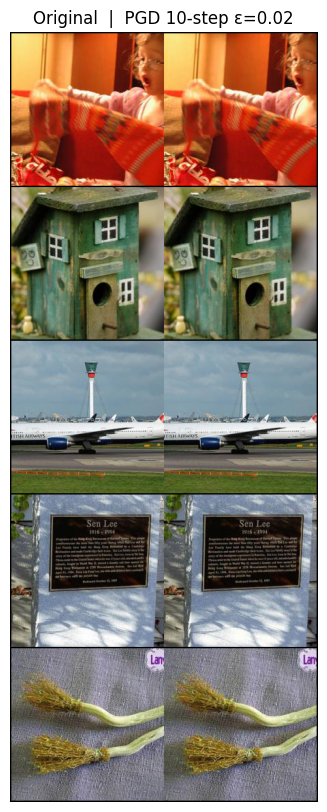


Saving PGD images to /content/AdvTestSet2_PGD ...
Done ✓


In [ ]:
#@title Task 3 – PGD 10‑step attack (ε = 0.02)
import os, numpy as np, torch, matplotlib.pyplot as plt
from pathlib import Path
from torchvision.utils import make_grid, save_image
from tqdm.auto import tqdm

EPS   = 0.02
STEPS = 10
ALPHA = EPS / STEPS * 1.5
OUT_DIR = Path("/content/AdvTestSet2_PGD")

def pgd_attack(model, x, y, eps=EPS, steps=STEPS, alpha=ALPHA):
    x_orig = x.detach()
    x_adv  = torch.clamp(x + torch.empty_like(x).uniform_(-eps, eps), -2.5, 2.5)
    for _ in range(steps):
        x_adv.requires_grad_(True)
        model.zero_grad()
        torch.nn.functional.cross_entropy(model(x_adv), y).backward()
        x_adv = x_adv + alpha * x_adv.grad.sign()
        x_adv = torch.max(torch.min(x_adv, x_orig + eps), x_orig - eps)
        x_adv = torch.clamp(x_adv, -2.5, 2.5).detach()
    return x_adv

pgd_list, orig_list = [], []
for x, y in tqdm(dl, desc="PGD generating"):
    x, y = x.to(DEVICE), y.to(DEVICE)
    adv  = pgd_attack(resnet34, x, y).cpu()
    pgd_list.append(adv); orig_list.append(x.cpu())

adv_pgd  = torch.cat(pgd_list)
orig_imgs = torch.cat(orig_list)

# ---------- verify L∞ distance ----------
max_diff = (adv_pgd - orig_imgs).abs().max().item()
print(f"L_inf max diff : {max_diff:.4f}  (≤ {EPS})")

# ---------- evaluate ----------
dl_pgd = DataLoader(
    torch.utils.data.TensorDataset(adv_pgd, torch.tensor(ds.targets)),
    batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
top1_pgd, top5_pgd = evaluate(resnet34, dl_pgd)
print(f"\nResNet‑34 on PGD set — Top‑1: {top1_pgd:.2f}%   Top‑5: {top5_pgd:.2f}%")

# ---------- visualize 5 examples ----------
def denorm(t):
    m = torch.tensor(MEAN).view(3,1,1); s = torch.tensor(STD).view(3,1,1)
    return torch.clamp(t * s + m, 0, 1)

idx = np.random.choice(len(ds), 5, replace=False)
rows = [torch.cat([denorm(orig_imgs[i]), denorm(adv_pgd[i])], dim=-1) for i in idx]
plt.figure(figsize=(4,10))
plt.imshow(make_grid(torch.stack(rows), nrow=1).permute(1,2,0))
plt.axis('off')
plt.title("Original  |  PGD 10‑step ε=0.02")
plt.show()

# ---------- save dataset (optional) ----------
if not OUT_DIR.exists():
    print(f"\nSaving PGD images to {OUT_DIR} ...")
    for (fp, _), adv in zip(ds.samples, adv_pgd):
        out = OUT_DIR / Path(fp).relative_to(DATASET_PATH)
        out.parent.mkdir(parents=True, exist_ok=True)
        save_image(denorm(adv), out, format='png')
    print("Done ✓")
else:
    print(f"{OUT_DIR} already exists, skip saving.")


Patch‑PGD generating:   0%|          | 0/16 [00:00<?, ?it/s]

L_inf max diff : 0.3000  (≤ 0.3)

ResNet‑34 on Patch‑PGD set — Top‑1: 30.60%   Top‑5: 72.40%


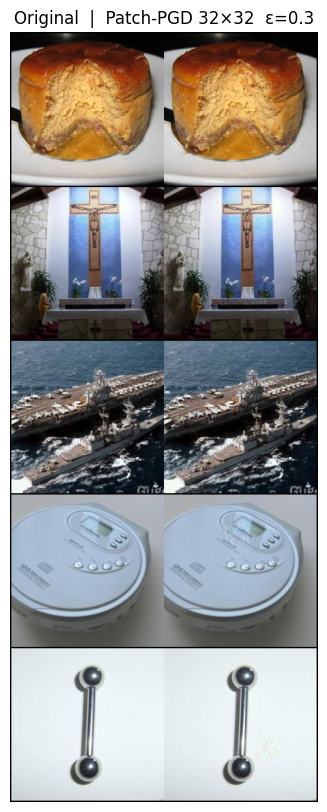


Saving Patch‑PGD images to /content/AdvTestSet3_Patch ...
Done ✓


In [ ]:
#@title Task 4 – 32×32 Patch‑PGD (ε = 0.3, 40 steps)
import os, numpy as np, torch, matplotlib.pyplot as plt
from pathlib import Path
from torchvision.utils import make_grid, save_image
from tqdm.auto import tqdm

EPS   = 0.3
PATCH = 32
STEPS = 40
ALPHA = EPS / np.sqrt(STEPS)
OUT_DIR = Path("/content/AdvTestSet3_Patch")

def patch_pgd_attack(model, x, y, eps=EPS, patch=PATCH, steps=STEPS, alpha=ALPHA):
    b, _, h, w = x.shape

    xs = torch.randint(0, w - patch + 1, (b,), device=x.device)
    ys = torch.randint(0, h - patch + 1, (b,), device=x.device)
    mask = torch.zeros_like(x)
    for i in range(b):
        mask[i, :, ys[i]:ys[i]+patch, xs[i]:xs[i]+patch] = 1.0

    x_orig = x.detach()
    x_adv  = torch.clamp(x + torch.empty_like(x).uniform_(-eps, eps) * mask, -2.5, 2.5)
    for _ in range(steps):
        x_adv.requires_grad_(True)
        model.zero_grad()
        torch.nn.functional.cross_entropy(model(x_adv), y).backward()
        x_adv = x_adv + alpha * x_adv.grad.sign() * mask
        x_adv = torch.max(torch.min(x_adv, x_orig + eps), x_orig - eps)
        x_adv = torch.clamp(x_adv, -2.5, 2.5).detach()
    return x_adv

patch_list, orig_list = [], []
for x, y in tqdm(dl, desc="Patch‑PGD generating"):
    x, y = x.to(DEVICE), y.to(DEVICE)
    adv  = patch_pgd_attack(resnet34, x, y).cpu()
    patch_list.append(adv); orig_list.append(x.cpu())

adv_patch = torch.cat(patch_list)
orig_imgs = torch.cat(orig_list)

# ---------- verify L∞ distance ----------
max_diff = (adv_patch - orig_imgs).abs().max().item()
print(f"L_inf max diff : {max_diff:.4f}  (≤ {EPS})")

# ---------- evaluate ----------
dl_patch = DataLoader(
    torch.utils.data.TensorDataset(adv_patch, torch.tensor(ds.targets)),
    batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
top1_patch, top5_patch = evaluate(resnet34, dl_patch)
print(f"\nResNet‑34 on Patch‑PGD set — Top‑1: {top1_patch:.2f}%   Top‑5: {top5_patch:.2f}%")

# ---------- visualize 5 examples ----------
def denorm(t):
    m = torch.tensor(MEAN).view(3,1,1); s = torch.tensor(STD).view(3,1,1)
    return torch.clamp(t * s + m, 0, 1)

idx = np.random.choice(len(ds), 5, replace=False)
rows = [torch.cat([denorm(orig_imgs[i]), denorm(adv_patch[i])], dim=-1) for i in idx]
plt.figure(figsize=(4,10))
plt.imshow(make_grid(torch.stack(rows), nrow=1).permute(1,2,0))
plt.axis('off')
plt.title("Original  |  Patch‑PGD 32×32  ε=0.3")
plt.show()

# ---------- save dataset (optional) ----------
if not OUT_DIR.exists():
    print(f"\nSaving Patch‑PGD images to {OUT_DIR} ...")
    for (fp, _), adv in zip(ds.samples, adv_patch):
        out = OUT_DIR / Path(fp).relative_to(DATASET_PATH)
        out.parent.mkdir(parents=True, exist_ok=True)
        save_image(denorm(adv), out, format='png')
    print("Done ✓")
else:
    print(f"{OUT_DIR} already exists, skip saving.")


In [ ]:
#@title Task 5 – Transfer attack evaluation on DenseNet‑121
import torchvision

from torch.utils.data import DataLoader, TensorDataset

targets_tensor = torch.tensor(ds.targets)  # same targets reused

if "dl_fgsm" not in globals() and "adv_imgs" in globals():
    dl_fgsm = DataLoader(TensorDataset(adv_imgs, targets_tensor),
                         batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
if "dl_pgd" not in globals() and "adv_pgd" in globals():
    dl_pgd  = DataLoader(TensorDataset(adv_pgd, targets_tensor),
                         batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
if "dl_patch" not in globals() and "adv_patch" in globals():
    dl_patch = DataLoader(TensorDataset(adv_patch, targets_tensor),
                          batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


densenet = torchvision.models.densenet121(weights="IMAGENET1K_V1").to(DEVICE)


# ---------- Test ----------
results = {
    "Clean" : evaluate(densenet, dl),
    "FGSM"  : evaluate(densenet, dl_fgsm),
    "PGD"   : evaluate(densenet, dl_pgd),
    "Patch" : evaluate(densenet, dl_patch),
}

# ---------- Print ----------
print("| Dataset | ResNet‑34 Top‑1 | ResNet‑34 Top‑5 | DenseNet‑121 Top‑1 | DenseNet‑121 Top‑5 |")
print("|---------|----------------|----------------|--------------------|--------------------|")
print(f"| Clean   | {top1:6.2f}% | {top5:6.2f}% | {results['Clean'][0]:6.2f}% | {results['Clean'][1]:6.2f}% |")
print(f"| FGSM    | {top1_fgsm:6.2f}% | {top5_fgsm:6.2f}% | {results['FGSM'][0]:6.2f}% | {results['FGSM'][1]:6.2f}% |")
print(f"| PGD     | {top1_pgd:6.2f}% | {top5_pgd:6.2f}% | {results['PGD'][0]:6.2f}% | {results['PGD'][1]:6.2f}% |")
print(f"| Patch   | {top1_patch:6.2f}% | {top5_patch:6.2f}% | {results['Patch'][0]:6.2f}% | {results['Patch'][1]:6.2f}% |")


| Dataset | ResNet‑34 Top‑1 | ResNet‑34 Top‑5 | DenseNet‑121 Top‑1 | DenseNet‑121 Top‑5 |
|---------|----------------|----------------|--------------------|--------------------|
| Clean   |  76.00% |  94.20% |  74.60% |  93.60% |
| FGSM    |   6.20% |  35.60% |  63.80% |  89.40% |
| PGD     |   0.20% |  13.80% |  65.60% |  91.20% |
| Patch   |  30.60% |  72.40% |  71.20% |  92.60% |
